In [28]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from seiz_eeg.dataset import EEGDataset

# Dependences
import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score, precision_score

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [4]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "./data"

DATA_ROOT = Path(data_path)

We have train segments, with labels...

In [5]:
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
display(clips_tr.iloc[100:115])

,label,start_time,end_time,date,sampling_rate,signals_path
id,,,,,,
pqejgcpt_s002_t001_0,0,0.0,12.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_1,0,12.0,24.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_2,0,24.0,36.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_3,0,36.0,48.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_4,0,48.0,60.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_5,0,60.0,72.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_6,0,72.0,84.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_7,0,84.0,96.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_8,0,96.0,108.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet


In [6]:
clips_tr.shape

(12993, 6)

... and test segments, unlabeled.

In [7]:
clips_te = pd.read_parquet(DATA_ROOT / "test/segments.parquet")
display(clips_te.head(10))

,start_time,end_time,date,sampling_rate,signals_path
id,,,,,
pqejgcvm_s001_t000_0,0.0,12.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_1,12.0,24.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_2,24.0,36.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_3,36.0,48.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_4,48.0,60.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_5,60.0,72.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_6,72.0,84.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_7,84.0,96.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_8,96.0,108.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet


The EEG signals are stored in separate files at the corresponding `signals_path`, and each of them contains all data from a given session. Next section illustrate a convenient interface for loading and iterating on data.

In [8]:
display(
    pd.read_parquet(DATA_ROOT / "train" / clips_tr.iloc[0]["signals_path"]).iloc[
        12000:12015
    ]
)

,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T3,T4,T5,T6,FZ,CZ,PZ
12000,59.718113,42.933436,14.857250,7.533027,-39.158892,-11.998233,-9.251650,-40.684771,42.933436,-21.458687,33.778158,10.889962,12.415842,11.500314,-28.782910,-25.425974,19.434889,-44.041707,-35.191604
12001,59.942979,44.684182,10.199301,6.537190,-39.544377,-12.994070,-6.585376,-40.154729,43.768654,-20.623469,33.087497,12.640709,14.471764,14.471764,-26.726988,-24.285580,15.082116,-48.089303,-35.882266
12002,63.075048,45.374844,7.533027,7.533027,-45.872762,-11.387881,-9.556825,-39.158892,44.459316,-15.355168,35.304038,15.162426,7.533027,22.791824,-32.750197,-19.932807,14.552074,-50.450401,-38.853716
12003,63.026862,45.326658,11.146953,9.315897,-48.667531,-10.825715,-13.267122,-39.512253,45.021482,-14.487826,34.645500,17.555647,8.095193,25.795398,-34.629438,-19.370641,13.283184,-52.939995,-39.512253
12004,61.227931,45.969134,7.211789,6.906613,-48.025056,-12.014295,-14.150526,-40.395657,47.495013,-15.371230,34.372448,17.282595,13.925660,27.658577,-26.357564,-20.864397,11.179077,-54.738926,-41.311185
12005,58.352852,45.840638,2.505655,5.252239,-48.153551,-13.363494,-12.447966,-42.050032,47.061342,-17.330781,35.769832,18.374804,18.985156,27.530082,-22.823948,-20.077364,11.355757,-53.646718,-41.134504
12006,59.830546,45.792453,5.204053,7.645460,-48.812088,-10.970272,-14.022031,-42.098218,46.707981,-16.768615,36.942351,18.936970,13.138627,32.059536,-28.670476,-20.430726,11.612748,-53.389727,-42.708570
12007,60.970940,45.712143,10.922086,10.311734,-48.892398,-9.829878,-16.848924,-40.957823,46.322495,-15.323045,38.082745,18.551485,9.701382,33.505106,-35.464657,-21.426563,13.668670,-54.385565,-44.619935
12008,58.706214,43.447417,15.981582,8.657360,-45.969134,-10.873901,-16.367067,-42.917374,45.583648,-19.418827,38.259426,14.760878,15.676406,28.798972,-28.879281,-24.911994,15.676406,-53.598532,-42.612198
12009,57.421262,43.993521,11.644871,5.846529,-42.676446,-14.600259,-13.684732,-43.897150,45.214225,-21.619306,39.721058,14.086279,20.189798,25.682965,-23.145186,-24.671065,14.391455,-51.221372,-42.676446


## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [11]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

In [12]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(21)

In [13]:
# Assume clips_tr is your DataFrame
# Step 1: Extract patient ID from the index (before first underscore)
clips_tr = clips_tr.copy()
clips_tr['patient_id'] = clips_tr.index.to_series().apply(lambda x: x.split('_')[0])

# Step 2: Get unique patient IDs
unique_patients = clips_tr['patient_id'].unique()

shuffled_patients = np.random.permutation(unique_patients)

val_patients = shuffled_patients[:21]
train_patients = shuffled_patients[21:]

# Step 4: Split DataFrame
train_df = clips_tr[clips_tr['patient_id'].isin(train_patients)].reset_index(drop=False)
val_df = clips_tr[clips_tr['patient_id'].isin(val_patients)].reset_index(drop=False)

# Step 5: Optional sanity check
print(f"Train patients: {train_df['patient_id'].nunique()}, Samples: {len(train_df)}")
print(f"Val patients: {val_df['patient_id'].nunique()}, Samples: {len(val_df)}")

train_df.drop(columns=['patient_id'], inplace=True)
train_df.set_index('id', inplace=True)
val_df.drop(columns=['patient_id'], inplace=True)
val_df.set_index('id', inplace=True)

Train patients: 76, Samples: 10277
Val patients: 21, Samples: 2716


In [20]:
# You can change the signal_transform, or remove it completely
train_split = EEGDataset(
    train_df,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

In [21]:
val_split = EEGDataset(
    val_df,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

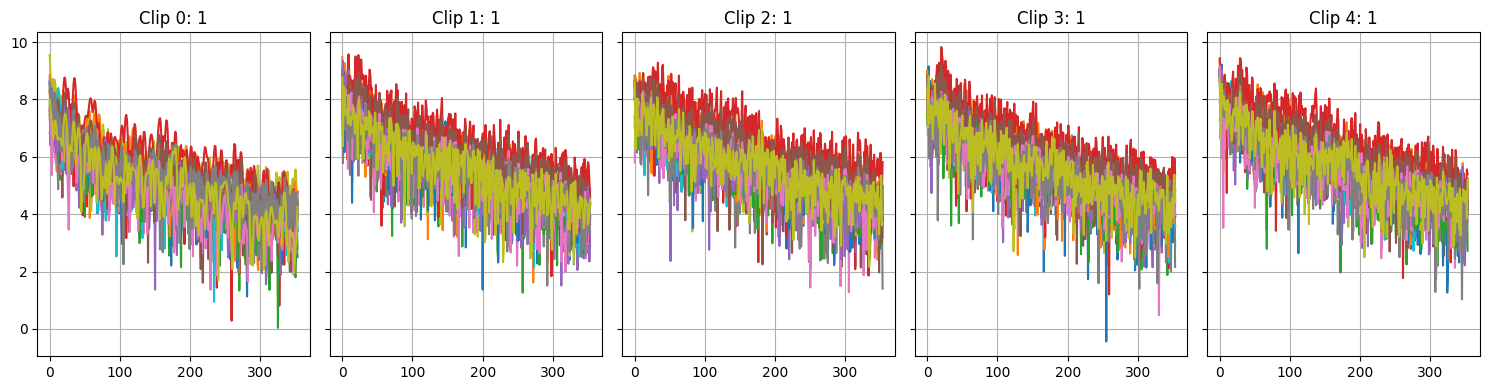

In [16]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i, (x, y) in enumerate(train_split):
    if i > 4:
        break
    axes[i].plot(x)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {y}"))

fig.tight_layout()
plt.show()

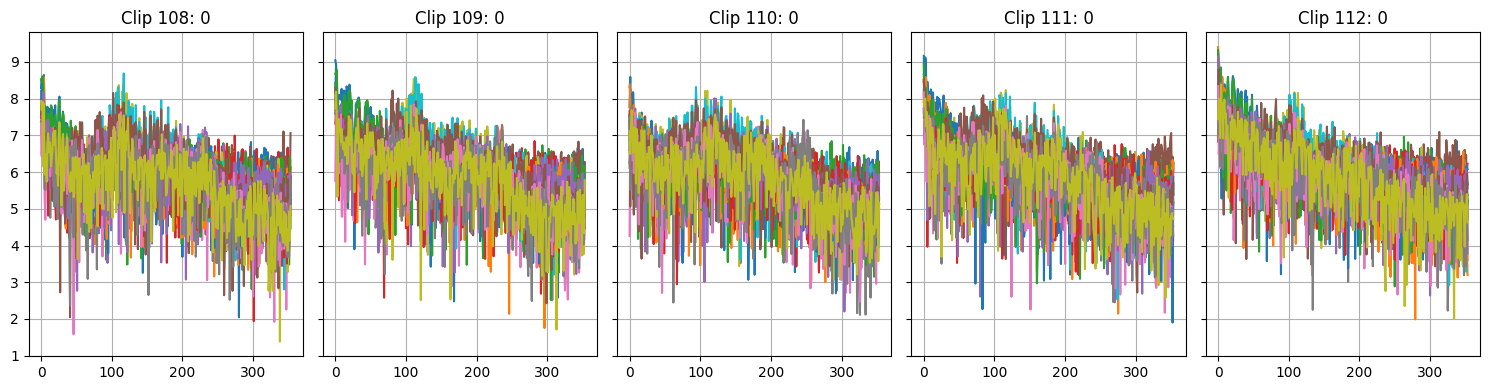

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i, ax in zip(range(108, 113), axes):
    x, y = train_split[i]
    ax.plot(x)
    ax.grid()
    ax.set(title=(f"Clip {i}: {y}"))

fig.tight_layout()
plt.show()

## Compatibility with PyTorch

The `EEGDataset` class is compatible with [pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allow you to load batched data.

In [29]:
loader_tr = DataLoader(train_split, batch_size=512, shuffle=True)
loader_val = DataLoader(val_split, batch_size=512, shuffle=True)

In [23]:
for x, y in loader_tr:
    print(x.shape)
    print(y.shape)
    break

torch.Size([512, 354, 19])
torch.Size([512])


## Baseline: LSTM model for sequential data

In this section, we provide a simple baseline for the project using an LSTM model without any special optimization.

In [24]:
# Define the model
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=19, hidden_dim=64, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, 1)  # Output for binary classification

    def forward(self, x):
        """
        x shape: [batch_size, seq_len, input_dim]
        """
        out, (h_n, c_n) = self.lstm(x)  # out shape: [batch_size, seq_len, hidden_dim]
        last_timestep = out[:, -1, :]  # [batch_size, hidden_dim]
        logits = self.fc(last_timestep)  # [batch_size, 1]
        return logits

In [25]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [26]:
# Instantiate model, loss, and optimizer, then move model to device
model = SimpleLSTM(input_dim=19, hidden_dim=64, num_layers=3, dropout=0.3).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [31]:
# Training loop
num_epochs = 1000
train_losses = []
val_f1s = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in loader_tr:
        # Move data to GPU (if available)
        x_batch = x_batch.float().to(device)  # [batch_size, seq_len, input_dim]
        y_batch = y_batch.float().unsqueeze(1).to(device)  # [batch_size, 1]

        # Forward pass
        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in loader_val:
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().unsqueeze(1).to(device)
            logits = model(x_batch)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            # Flatten and collect predictions and labels
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(y_batch.view(-1).cpu().numpy())
    f1 = f1_score(all_labels, all_preds)
    val_f1s.append(f1)

    avg_loss = running_loss / len(loader_tr)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Val F1 Score: {f1:.4f}")

Epoch 1/1000 - Loss: 0.4288, Val F1 Score: 0.0000
Epoch 2/1000 - Loss: 0.4242, Val F1 Score: 0.0000
Epoch 3/1000 - Loss: 0.4320, Val F1 Score: 0.0000
Epoch 4/1000 - Loss: 0.4253, Val F1 Score: 0.0000
Epoch 5/1000 - Loss: 0.4224, Val F1 Score: 0.0000
Epoch 6/1000 - Loss: 0.4211, Val F1 Score: 0.0000
Epoch 7/1000 - Loss: 0.4287, Val F1 Score: 0.0000
Epoch 8/1000 - Loss: 0.4303, Val F1 Score: 0.0000
Epoch 9/1000 - Loss: 0.4123, Val F1 Score: 0.0000
Epoch 10/1000 - Loss: 0.4046, Val F1 Score: 0.0000
Epoch 11/1000 - Loss: 0.4281, Val F1 Score: 0.0000
Epoch 12/1000 - Loss: 0.4116, Val F1 Score: 0.0000
Epoch 13/1000 - Loss: 0.4134, Val F1 Score: 0.0000
Epoch 14/1000 - Loss: 0.4238, Val F1 Score: 0.0000
Epoch 15/1000 - Loss: 0.4204, Val F1 Score: 0.0000
Epoch 16/1000 - Loss: 0.4092, Val F1 Score: 0.0000
Epoch 17/1000 - Loss: 0.4262, Val F1 Score: 0.0000
Epoch 18/1000 - Loss: 0.4098, Val F1 Score: 0.0000
Epoch 19/1000 - Loss: 0.4106, Val F1 Score: 0.0000
Epoch 20/1000 - Loss: 0.4052, Val F1 Sco

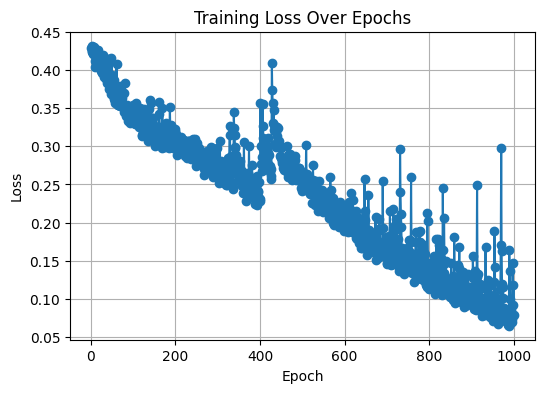

In [32]:
# Plot the training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [34]:
max(val_f1s[:200])

0.6422872340425532

# Submission

In [ ]:
# Create test dataset
dataset_te = EEGDataset(
    clips_te,  # Your test clips variable
    signals_root=DATA_ROOT
    / "test",  # Update this path if your test signals are stored elsewhere
    signal_transform=fft_filtering,  # You can change or remove the signal_transform as needed
    prefetch=True,  # Set to False if prefetching causes memory issues on your compute environment
    return_id=True,  # Return the id of each sample instead of the label
)

# Create DataLoader for the test dataset
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

In [ ]:
# Generate the submission file for Kaggle

# Set the model to evaluation mode
model.eval()

# Lists to store sample IDs and predictions
all_predictions = []
all_ids = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch in loader_te:
        # Assume each batch returns a tuple (x_batch, sample_id)
        # If your dataset does not provide IDs, you can generate them based on the batch index.
        x_batch, x_ids = batch

        # Move the input data to the device (GPU or CPU)
        x_batch = x_batch.float().to(device)

        # Perform the forward pass to get the model's output logits
        logits = model(x_batch)

        # Convert logits to predictions.
        # For binary classification, threshold logits at 0 (adjust this if you use softmax or multi-class).
        predictions = (logits > 0).int().cpu().numpy()

        # Append predictions and corresponding IDs to the lists
        all_predictions.extend(predictions.flatten().tolist())
        all_ids.extend(list(x_ids))

# Create a DataFrame for Kaggle submission with the required format: "id,label"
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})

# Save the DataFrame to a CSV file without an index
submission_df.to_csv("submission_seed1.csv", index=False)
print("Kaggle submission file generated: submission.csv")

Kaggle submission file generated: submission.csv
